<a href="https://colab.research.google.com/github/paulodowd/woiec2023/blob/main/Worksheet_4_Convolutional_Neural_Networks_Sound_Applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **A Brief Introduction to Speech Recognition and Sound Classification**

---

Last worksheet, we covered the basic priniciples of building a machine learning model. In this worksheet, we will explore how we can apply these same principles to different problem areas, to gain an understanding of how we can build powerful models for a range of application areas. Yesterday, we looked at a computer vision based problem, today we will aim to look at a task involving sound.

**By the end of this worksheet you will:**
1. Understand the importance of appropriate preprocessing steps, and how to research appropriate steps
2. Have an understanding of how to approach different problems with a data-driven perspective
3. Understand how to go about building a convolutional neural network that classifies sound.

### How we hear sound

Our ears detect sound by collecting sound waves through the outer ear, which vibrate the eardrum in the middle ear.

![Pressure waves and the ear](https://res.cloudinary.com/dk-find-out/image/upload/q_70,c_pad,w_1200,h_630,f_auto/DK_aw_Ear_pkaizy.jpg) These vibrations are then transferred to the cochlea in the inner ear, where hair cells convert them into neural signals. These signals are sent to the brain via the auditory nerve, allowing us to perceive and interpret sound.

### How computers hear sound

Sound is stored digitally by sampling the analog sound wave at regular intervals and quantising the amplitude of each sample. You might have seen representations of sound waves before - they look something like the image below.

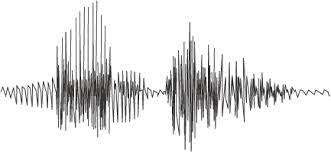

We can convert this waveform into a special type of image called a spectrogram, which looks something akin to this:

![Spectrogram Example](https://miro.medium.com/v2/resize:fit:2000/1*V2mgZ7y0ngd3q4DZ01xkEQ.png)

#### **What actually are spectrograms?**
A spectrogram is a visual representation of the frequency content of a signal over time. It provides a way to analyze and display the varying intensity or amplitude of different frequencies present in a sound signal as it evolves over time. In a spectrogram, the vertical axis represents frequency, the horizontal axis represents time, and the color or grayscale intensity represents the magnitude or energy of each frequency component at a specific time. Brighter or darker areas in the spectrogram indicate higher or lower energy levels respectively, allowing for easy identification of frequency patterns, harmonics, and time-varying spectral characteristics in the sound signal.


# Before you get started

The following sections contain information about downloading, exploring, and then preprocessing our sound files into spectrograms. I would recommend reading through the explanatory text and code block outputs, to gain an understanding of the data before moving on to the Model Selection Stage and ensuing tasks.


## Import Required Packages and Download the Data

Make sure you run the following code blocks (but don't edit them), to install the right packages, download the dataset we will be using, and to define some useful helper functions.

In [ ]:
pip install tensorflow-io[tensorflow]

In [ ]:
# import required modules
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio

from pathlib import Path
from random import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [ ]:
# step 1: download the data
DATASET_PATH = 'data/mini_speech_commands'

data_dir = Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [ ]:
def load_sound_file(sound_filepath):
    """ load the raw sound files """

    # load file
    file_contents = tf.io.read_file(sound_filepath)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

    # correct shape
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # G6000hz = sound_filepath amplitude
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


## Stage 1: Data Preparation

The dataset's audio clips are stored in eight folders corresponding to each speech command: no, yes, down, go, left, up, right, and stop. You can view these in the sidebar by clicking the file icon.

The [Dataset Paper](https://arxiv.org/pdf/1804.03209.pdf) is available on arxiv. This paper provides further information about the dataset.

### Step 1: Exploring the data

The data should already by downloaded if you have run the helper functions. If the running the cell below causes an error, try running the helper functions first.

**Tasks:**
1. Choose which two classes to examine. Make changes to the code block below based on the classes you have chosen to investigate, and plot the raw waveform data.
2. Refer to the dataset paper to determine key characteristics of the data, that will aid us in ensuring we are preprocessing it accurately.

In [ ]:
# initialise key filepaths
data_folder = os.path.join(os.getcwd(), "data", "mini_speech_commands")
class_folders = [os.path.join(data_folder, i) for i in os.listdir(data_folder)]

# select what classes we will train on, you can choose from:
# "go",
word_1 = "go"
word_2 = "stop"
labels = [word_1, word_2]
dataset_class_folders = []

for label in labels:
  for class_folder in class_folders:
    if label in class_folder:
      dataset_class_folders.append(class_folder)


# plot examples of data
fig, axes = plt.subplots(2, 4, figsize=(16, 9))

for i in range(0, len(dataset_class_folders)):
  for j in range (0,4):

    sound_filename = os.path.join(dataset_class_folders[i], os.listdir(dataset_class_folders[i])[j]) # get the first file in the directory
    wav = load_sound_file(sound_filename)

    title = os.path.basename(dataset_class_folders[i])
    wav_np = wav.numpy()
    ax = axes[i, j]
    ax.plot(wav_np)

    if word_1 in sound_filename:
      ax.set_title(word_1)
    elif word_2 in sound_filename:
      ax.set_title(word_2)


plt.show()

What deductions can you make about the data?



1. The sound clips are not all the same length. Most ML/DL models take inputs of a fixed size, so we will need to address this at the preprocessing stage.

You can uncomment the code block below to investigate the length of the sound sequences for your chosen classes by changing the variable `chosen_word`. The `load_sound_file` function returns the wav files as a Tensor, so you may find the [Tensor documentation](https://www.tensorflow.org/api_docs/python/tf/Tensor) helpful here.

In [ ]:
# lengths = []
# chosen_word = word_2
# for file in os.listdir(os.path.join('data', 'mini_speech_commands', chosen_word)):

#     tensor_wave = load_sound_file(os.path.join('data', 'mini_speech_commands', chosen_word, file))
#     lengths.append(tensor_wave.__len__())

# myset = set(lengths)
# print(myset)

### Exploring appropriate data representations

We can use the raw 1D waveform, or spectrogram as input to our ML models, or look to alternative representations, such as spectrograms. Research papers provide a useful source of inspiration when approaching our own DL problems. Many papers describe sound classification, and include key details about the data preprocessing, and model architecture.



### Preprocess the Data into Spectrograms

These helper functions convert the raw waveform for the chosen classes into a spectrogram. This code block will take a few minutes to run.

In [ ]:
def preprocess(file_path, label):
  spectrograms, labels = [], []

  for i in os.listdir(file_path):

    i = os.path.join(file_path, i)
    wav = load_sound_file(i)

    # ensure all sequences are the same length
    wav = wav[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)

    # preprocessing for waveforms here
    spectrogram = tf.signal.stft(wav, frame_length=255, frame_step=320)

    # leave these here
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    spectrograms.append(spectrogram)
    labels.append(label)

  return spectrograms, labels

# Defining the positive and negative paths
root_folder_go_data = os.path.join('data', 'mini_speech_commands', word_1)
root_folder_stop_data = os.path.join('data', 'mini_speech_commands', word_2)

go_filepaths = [os.path.join(root_folder_go_data, i) for i in os.listdir(root_folder_go_data)]
stop_filepaths = [os.path.join(root_folder_stop_data, i) for i in os.listdir(root_folder_stop_data)]

# Creating the Database
go_spectrograms, go_labels = preprocess(root_folder_go_data, 0)
stop_spectrograms, stop_labels = preprocess(root_folder_stop_data, 1)


# concatenate database
spectrogram_data = np.array(go_spectrograms + stop_spectrograms)

label_data = np.array(go_labels + stop_labels)

# label_data = pd.get_dummies(label_data)
# print(label_data.head())
h, w, c = spectrogram_data[0].shape

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

n_plots=4

class_for_title = 0
for spectrogram_class in [go_spectrograms, stop_spectrograms]:

  fig, axes = plt.subplots(n_plots)
  for i in range(0,n_plots):
    plot_spectrogram(spectrogram_class[i].numpy(), axes[i])
    axes[0].set_title('Class ' + str(class_for_title))
  class_for_title +=1
  plt.show()

# Stage 2: Model Selection

## Step 1: Build Model

Here we will focus on building a simple baseline model that works end-to-end. We'll use similar code to the model that we built yesterday - review the model, and familiarise yourself with its architecture by running the code block below and examining the output.

In [ ]:
def build_model(nrows, ncols, nchannels):

  # define our input layer
  inputs = keras.Input(shape=(nrows, ncols, nchannels))

  # define the core model: a 2d-convolutional layer, followed by a max pooling layer
  conv2d = keras.layers.Conv2D(32, 3, activation="relu")(inputs)
  pooling = keras.layers.MaxPooling2D((2, 2))(conv2d)

  # flatten the output from the convolutional block
  flatten = keras.layers.Flatten()(pooling)

  # define output layer
  outputs = keras.layers.Dense(1, activation="sigmoid")(flatten)

  # build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  print(model.summary())

  return model

build_model(h,w,c)

This model is very simple, and worked relatively well for the very simple MNIST data. We'll use it as a baseline, and can later refine it if necessary.

## Step 2: Train

Once again we will use the same training code as from our worksheet yesterday.

#### Training loop

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(spectrogram_data, label_data, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
# training procedure: we will use cross validation to get a better idea of how our model is performing
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42)

# define optimizer for model compilation
lr = 0.01
opt = keras.optimizers.Adam(learning_rate=lr)

# store model accuracy
accuracies = []


for i, (train_index, val_index) in enumerate(kf.split(X_train)): # for each fold
  print(f"Fold {i}")

  # retrieve fold data
  X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
  print(X_train_fold.shape, X_val_fold.shape)
  y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

  # build model
  digit_predictor = build_model(X_train.shape[1], X_train.shape[2], 1)
  digit_predictor.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  # define callbacks
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0)

  # train model
  history = digit_predictor.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[callback], verbose=1)

  # evaluate performance on the validation set
  loss, acc = digit_predictor.evaluate(X_val_fold, y_val_fold, verbose=0)

  accuracies.append(acc)

  print(f"Accuracy: {acc}" )



In [ ]:
accuracies

## Step 3: Refine the Model

Now that we have our data in the correct format, and a simple model working end-to-end, let's see if we can improve the performance. There are a number of ways we can go about this:

1. Refining the model architecture
2. Tuning the model hyperparameters
3. Varying our data preprocessing methods to get different representations of the data



**Task:** Improve performance of the network by refining the model architecture in the code block below, and then rerunning the training loop (also below). Adding layers to the model increases its complexity, allowing it to gain a more nuanced understanding of the data. We can tell the model is struggling to learn if the training loss doesn't reduce - the smaller this value is, the better.
1. We only have 1 Dense layer at the end of our model, but it's generally considered good practice to have at least two. Add more complexity to the model by adding an additional Dense layer to the model (see code block below for location).
2. Train the model again. Has performance improved? Which model performs better?
3. Convolutional neural networks have been shown to be more effective on many types of data when two convolutional layers are applied consecutively. Add a second convolutional layer below the first (see code block below for location) Feel free to experiment with the number of filters in the layer.
4. Record your changes and the overall accuracy - sometimes simpler models can perform surprisingly well. Once you are happy with the overall accuracy you can move onto testing the model's performance on the test set.

Resources:
1. The [Keras Functional API](https://keras.io/guides/functional_api/). This explains in more detail how to define the layers.
2. [Convolutional Layer documentation](https://keras.io/api/layers/convolution_layers/convolution2d/)
3. [Dense Layer documentation](https://keras.io/api/layers/core_layers/dense/)
4. Research papers often provide a useful starting point when approaching ML/DL problems - we can look for similar taks/problems, and see what kind of models have performed well before trying some of those architectures. [This](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9088863&casa_token=PDCtcacEHaEAAAAA:Dx7DoClLWRLZ3zhmJXcIuPSKAtJn9GoiI5vB-62WN9UVM6BAJP_0HmwKLvW1DYcYa-GWBnUr9ts) paper provides a couple of ideas - you could try implementing one of the convolutional blocks shown in Figure 3.

In [ ]:
def build_new_model(nrows, ncols, nchannels):

  # define our input layer
  inputs = keras.Input(shape=(nrows, ncols, nchannels))

  # define the core model: a 2d-convolutional layer, followed by a max pooling layer
  conv2d = keras.layers.Conv2D(32, 3, activation="relu")(inputs)

  #### ADD CONVOLUTIONAL LAYER BELOW THIS LINE: make sure you complete task 1 before filling this out!
  ### review the keras documentation for the Conv2D layer, and implement that layer here,
  # make sure you link it to the previous conv2d layer by correctly setting the output
  # on BOTH the input to the new layer, and the output of the pooling layer, template below

  # conv2d = keras.layers.Conv2D(??, ??, activation="relu")(previous_layer)

  #### ADD CONV LAYER ABOVE THIS LINE

  pooling = keras.layers.MaxPooling2D((2, 2))(conv2d) # don't forget to change this when building more convolutional layers

  # flatten the output from the convolutional block
  flatten = keras.layers.Flatten()(pooling)

  # and define the output layer
  ## fully-connected/dense layers

  #### ADD DENSE LAYER BELOW THIS LINE
  # general format for a new keras layer:
  # new_layer = keras.layers.LAYERNAME(.....)(previous_layer)
  # where the previous layer is the layer above this one in the model architecture (i.e. flatten)
  # dense1 = keras.layers.Dense(??, activation=??)(previous_layer) # don't forget to set previous_layer to the output of your new layer
  #### ADD DENSE LAYER ABOVE THIS LINE

  outputs = keras.layers.Dense(1, activation="sigmoid")(flatten)

  # build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  print(model.summary())

  return model

build_new_model(h,w,c)

In [ ]:
accuracies = []

for i, (train_index, val_index) in enumerate(kf.split(X_train)): # for each fold
  print(f"Fold {i}")

  # retrieve fold data
  X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
  print(X_train_fold.shape, X_val_fold.shape)
  y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

  # build model
  digit_predictor = build_new_model(X_train.shape[1], X_train.shape[2], 1)
  digit_predictor.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  # define callbacks
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0)

  # train model
  history = digit_predictor.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[callback], verbose=1)

  # evaluate performance on the validation set
  loss, acc = digit_predictor.evaluate(X_val_fold, y_val_fold, verbose=0)

  accuracies.append(acc)

  print(f"Accuracy: {acc}" )

In [ ]:
accuracies

# Stage 3: Evaluate Model Performance on Test Set

Once you are happy with your model's performance on the validation set, we can retrain on the full dataset, and make predictions on the test set.

**Task:**
1. Add the number of epochs you would like to train the model for - choose this based on how many epochs your model typically trained for during the cross validation.

In [ ]:
# define key parameters
num_epochs = ??
batchsize = 32

# initialise model
digit_predictor = build_model(X_train.shape[1], X_train.shape[2], 1)
digit_predictor.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# train on full dataset
hist = digit_predictor.fit(X_train, y_train, epochs=num_epochs, batch_size=batchsize)

# evaluate performance of model on test set
loss, acc = digit_predictor.evaluate(X_test, y_test, verbose=0)
print(loss, acc)

How does the model perform on unseen (test set) data? Is this better or worse than expected?